# Transformer Architecture Reimplimenation

The Transformer architecture from  ["Attention is All You Need" (Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin, arxiv, 2017)](https://arxiv.org/abs/1706.03762) is the backbone of modern large language models (LLMs). It introduced the concept of self-attention, which made sequence-to-sequence models more effective and accurate. The self-attention mechanism enables a high degree of parallelism, making the training of large models feasible. Additionally, it allows the model to capture long-range dependencies more effectively than RNNs, where information often degrades over long sequences.


## Previous implimentations  Sequence-to-sequence (aka seq2seq)

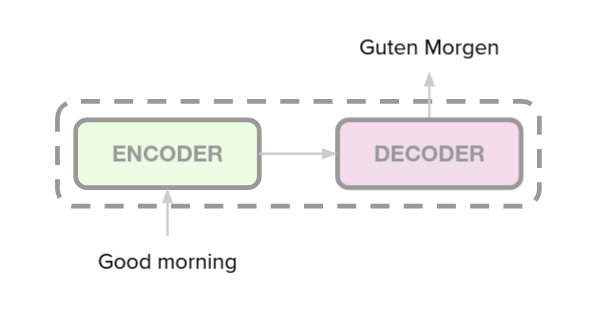


Seq2Seq models form the backbone for many tasks such as Neural Machine Translation (NMT). These initial models employed RNNs as the backbone for both their encoders and decoders. An encoder takes a variable-sized input sequence and transforms it into a fixed-size context vector. The decoder produces the output sequence based on the context vector generated by the encoder.<br>
Limitations of Vanilla Seq2Seq Models<br>
It compresses the entire input sequence into a single fixed-size context vector, and this can potentially lead to information loss, especially in long sequences.
Long-range dependencies are really hard to be captured effectively due to the poor performance of RNNs over long sequences.
<br>
The introduction of the attention mechanism addressed these limitations. Attention allows the model to focus on specific parts of the input sequence during decoding, preserving more context and improving performance. The mechanism enables the decoder to "attend to" different encoder outputs dynamically, rather than relying solely on a single context vector. This innovation led to significant improvements in tasks like machine translation.<br>
Transformers are a very different approach from the rest of Seq2Seq models. It completely abolishes recurrence and uses self-attention between all tokens in input and output sequences. All these provide a few benefits:
Parallelization: Unlike RNNs, Transformers compute everything at once, which makes it possible to train very fast on modern hardware.
Global Dependencies: Self-attention allows the model to better capture long-range dependencies than RNNs.
Scalability: Transformers can process larger datasets and more complex models, which is the need of modern NLP tasks.
Transformers have become the de facto standard in NLP and power state-of-the-art language models such as BERT, GPT, and T5. These models have achieved remarkable success across various tasks

## Pytorch Implimentation of Transformer model


## Importing Libraries  

In [ ]:
pip install evaluate datasets sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from typing import Any
from tqdm import tqdm
import warnings
import math
import torch
import torch.nn as nn
import warnings

## Building core Components of a Transformer as stated in paper

Here we first implement the core components as follows:<br>
1)The InputEmbeddings class generates token embeddings for the input sequence. It scales the embeddings by the square root of the model's dimensionality to stabilize training.<br>
2)The PositionalEmbeddings class adds positional information to token embeddings, enabling the model to understand the order of tokens in a sequence.
<br>
3)The LayerNormalization class normalizes input features along the last dimension to stabilize and speed up training.<br>
4)The ResidualConnection class implements residual connections combined with dropout and layer normalization.<br>



In [ ]:
class Inputembeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)
class positionalemb(nn.Module):
    def __init__(self, d_model: int, seq_length: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_length = seq_length
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(self.seq_length, d_model)
        position = torch.arange(0, self.seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)
class ResidualConnection(nn.Module):
    def __init__(self, features: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(features)

    def forward(self, x, sublayer):
        return self.norm(x + self.dropout(sublayer(x)))

class ResidualConnection(nn.Module):

        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)

        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

The FeedForwardBlock class implements a position-wise feedforward network, a key component of the Transformer architecture.<br>This block applies two linear transformations separated by a non-linear activation function (ReLU) and dropout.

In [ ]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))


The MultiHeadAttentionBlock implements the multi-head attention mechanism, as described in the "Attention Is All You Need" paper.
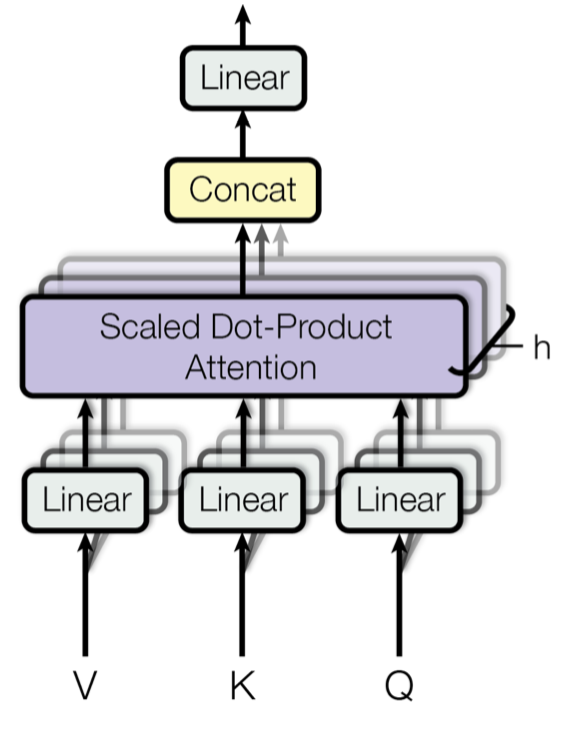

In [ ]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)


        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x)

#### Encoder Block and Encoder

##### Encoder Block:
The `EncoderBlock` implements a single layer of the Transformer encoder. It consists of:
1. **Self-Attention**: A multi-head self-attention mechanism that allows each token to attend to all other tokens in the input.
2. **Feed-Forward Network**: A fully connected network applied to each token independently.
3. **Residual Connections**: Wraps each sub-layer with residual connections and layer normalization for stability.

##### Encoder:
The `Encoder` consists of a stack of `EncoderBlock`s and performs the following:
1. Passes input through each `EncoderBlock` sequentially.
2. Applies layer normalization to the final output.




In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

class Encoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

#### Decoder Block and Decoder

#### Decoder Block:
The `DecoderBlock` implements a single layer of the Transformer decoder. It consists of:
1. **Masked Self-Attention**: Computes attention within the target sequence, ensuring no information from future positions is used.
2. **Cross-Attention**: Computes attention between the target sequence and the encoder output, focusing on relevant source positions.
3. **Feed-Forward Network**: A fully connected network applied to each token independently.
4. **Residual Connections**: Wraps each sub-layer with residual connections and layer normalization for stability.

#### Decoder:
The `Decoder` consists of a stack of `DecoderBlock`s. It processes the target sequence along with the encoder's output.

#### Features:
1. **Causal Masking**: Prevents "peeking" at future tokens in the target sequence.
2. **Cross-Attention**: Enables the decoder to focus on relevant parts of the encoder's output.
3. **Residual Connections**: Stabilizes training and helps gradient flow.


In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x
class Decoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)
    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)


#### Projection Layer

The `ProjectionLayer` maps the decoder's output to the vocabulary space for token predictions.




In [ ]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        return self.proj(x)

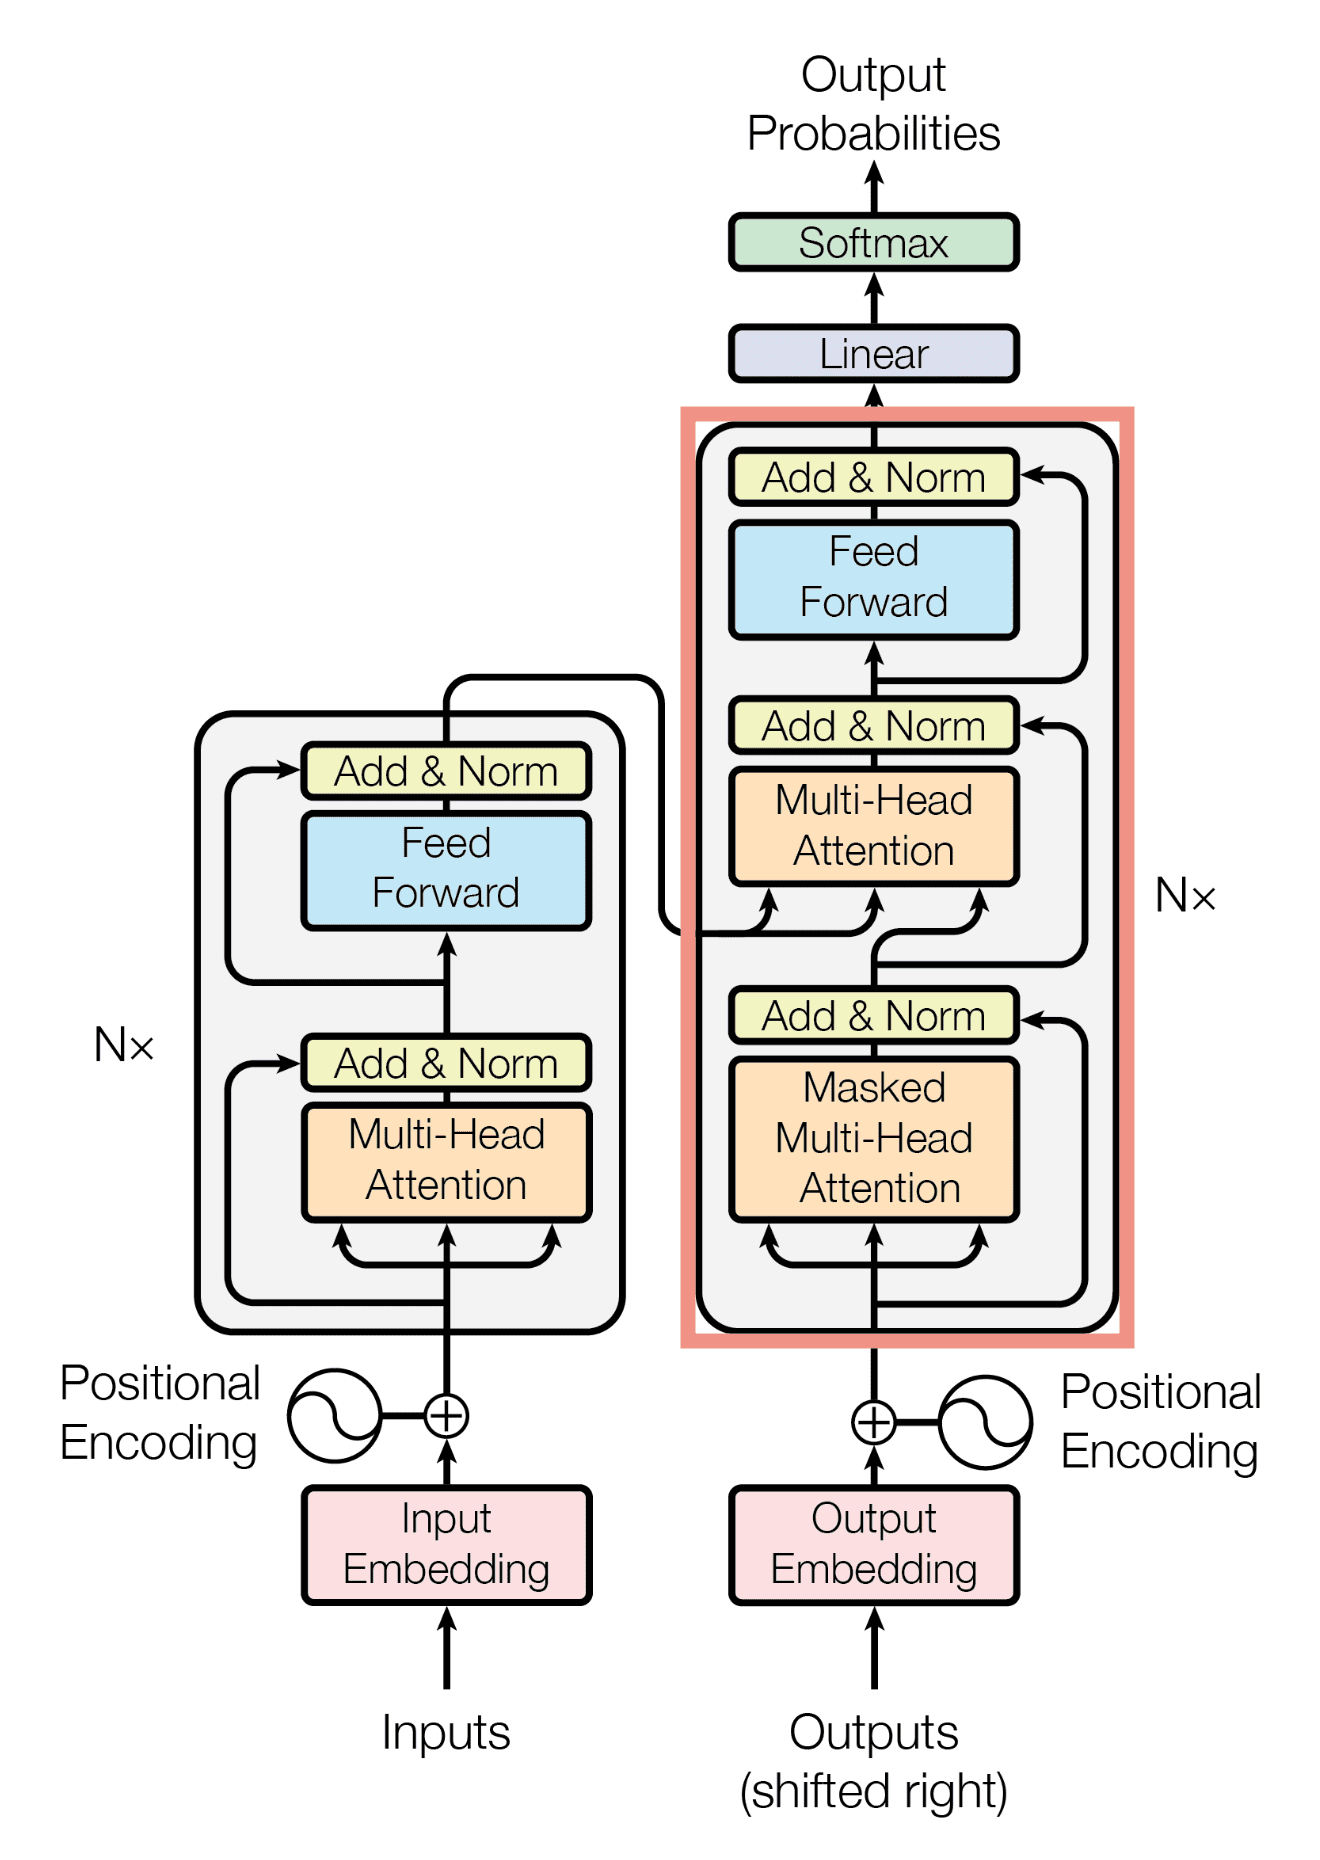

#### Transformer
The Transformer class integrates the Encoder, Decoder, embedding layers, positional encodings, and projection layer to implement the complete Transformer architecture.



In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: Inputembeddings, tgt_embed: Inputembeddings, src_pos: positionalemb, tgt_pos: positionalemb, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer
    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    def project(self, x):
        return self.projection_layer(x)


#### Compiling all that together in Transformer
The build_transformer function is responsible for creating the complete Transformer model. This function initializes all the key components, including embedding layers, positional encoding, encoder and decoder blocks, and the final projection layer.

In [ ]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:

    src_embed = Inputembeddings(d_model, src_vocab_size)
    tgt_embed = Inputembeddings(d_model, tgt_vocab_size)

    src_pos = positionalemb(d_model, src_seq_len, dropout)
    tgt_pos = positionalemb(d_model, tgt_seq_len, dropout)
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

## Now applying all that in a translation task

Now applying all that in a Translation task from Deutsch to English using Opus books for de-en translation

#### Tokenizer and Dataset Preparation

This section defines the process for building a tokenizer and preparing datasets for training a bilingual machine translation model.



##### Overview

The tokenizer is built or loaded depending on whether the tokenizer file already exists. If it doesn’t, a new word-level tokenizer is created and trained using sentences from the dataset, with whitespace used for token splitting. Special tokens such as `[UNK]`, `[PAD]`, `[SOS]`, and `[EOS]` are added, and the tokenizer is saved to a specified file path. Otherwise, an existing tokenizer is loaded directly.

A helper function iterates over all sentences in a specific language from the dataset to provide input for the tokenizer.

The dataset preparation process includes loading the OpusBooks dataset, splitting it into training and validation sets (90% for training and 10% for validation), and building tokenizers for both the source and target languages. The data is processed using a `BilingualDataset` class, and the maximum lengths of sentences in both languages are calculated. Finally, `DataLoader` objects are created for both the training and validation datasets.

A causal mask is also implemented for training transformers, ensuring that the model only attends to previous tokens when predicting the next token.


##### Key Steps in the Process

1. **Tokenizer Creation or Loading**:
   - If the tokenizer file exists, it is loaded.
   - If not, a new tokenizer is trained using the dataset and saved for future use.

2. **Sentence Iterator**:
   - Extracts all sentences in the specified language from the dataset.

3. **Dataset Preparation**:
   - Loads the dataset and splits it into training and validation sets.
   - Builds tokenizers for both source and target languages.
   - Calculates the maximum sentence lengths for both languages.
   - Creates DataLoaders for batch processing during training and validation.

4. **Causal Mask**:
   - Creates a square matrix to ensure the model does not access future tokens during training.


This process ensures that the data is properly prepared and tokenized, allowing for effective training of a bilingual machine translation model. The use of tokenizers, dataset splitting, and causal masking enables efficient and structured learning.


In [ ]:
def build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    if not Path.exists(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]'))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
                                                     "[SOS]", "[EOS]"], min_frequency = 2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]
def get_ds(config):
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])
    train_ds_size = int(0.9 * len(ds_raw))
    val_ds_size = len(ds_raw) - train_ds_size
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))
    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True)
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)
    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt
def casual_mask(size):
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

### BilingualDataset Class

The `BilingualDataset` class is designed to preprocess and handle bilingual sentence pairs for training machine translation models. It tokenizes the sentences in both source and target languages, pads them to a fixed sequence length, and generates the necessary input and output tensors required for model training.
#### Key Parameters and Initialization

1. **Input Arguments**:
   - `ds`: The dataset containing bilingual sentence pairs.
   - `tokenizer_src` and `tokenizer_tgt`: Tokenizers for the source and target languages, respectively.
   - `src_lang` and `tgt_lang`: Strings specifying the source and target languages.
   - `seq_len`: The fixed sequence length for all input and output tensors.

2. **Special Tokens**:
   The class initializes the `[SOS]`, `[EOS]`, and `[PAD]` tokens using the target language tokenizer. These tokens play critical roles in marking the start, end, and padding of sentences.

#### Core Methods
#### 1. `__len__`
This method returns the total number of sentence pairs in the dataset.
#### 2. `__getitem__`
This method processes a single sentence pair at the specified index. Here's the step-by-step breakdown:

- **Retrieve Source and Target Texts**:
  The source and target texts are extracted based on the language keys.

- **Tokenization**:
  The source and target texts are tokenized using their respective tokenizers.

- **Padding**:
  The number of padding tokens required is calculated to ensure that all tensors match the fixed sequence length. If a sentence exceeds the sequence length, an error is raised.

- **Tensor Construction**:
  - **Encoder Input**: Combines the `[SOS]` token, tokenized source text, `[EOS]` token, and padding tokens.
  - **Decoder Input**: Combines the `[SOS]` token, tokenized target text, and padding tokens.
  - **Label**: Combines the tokenized target text, `[EOS]` token, and padding tokens.

- **Mask Creation**:
  - **Encoder Mask**: Identifies non-padding tokens in the encoder input for attention mechanisms.
  - **Decoder Mask**: Combines the non-padding mask of the decoder input with a causal mask to ensure the decoder only attends to previous tokens during training.

- **Output Dictionary**:
  Returns a dictionary containing the following elements:
  - `encoder_input`: The input tensor for the encoder.
  - `decoder_input`: The input tensor for the decoder.
  - `encoder_mask`: A mask indicating non-padding tokens for the encoder.
  - `decoder_mask`: A mask combining non-padding and causal constraints for the decoder.
  - `label`: The expected output tensor for training.
  - `src_text`: The original source text.
  - `tgt_text`: The original target text.


#### Key Features and Validations

1. **Padding and Length Check**:
   Ensures all tensors have a length equal to the predefined sequence length (`seq_len`). This standardization is crucial for batch processing in neural networks.

2. **Error Handling**:
   If any sentence exceeds the allowed sequence length, a `ValueError` is raised to notify that the input needs adjustment.

3. **Masking**:
   Masks are created to control which tokens the model can attend to during training. The encoder mask identifies valid tokens in the source input, while the decoder mask combines causal constraints with padding token identification.


#### Summary

The `BilingualDataset` class simplifies the preprocessing pipeline for bilingual datasets by:
- Handling tokenization, padding, and tensor creation for both source and target languages.
- Ensuring that all inputs and outputs conform to the specified sequence length.
- Generating masks to guide the model's attention mechanism during training.

This class is a fundamental component for preparing data in sequence-to-sequence tasks like machine translation.


In [ ]:
class BilingualDataset(Dataset):
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')
        encoder_input = torch.cat(
            [
            self.sos_token,
            torch.tensor(enc_input_tokens, dtype = torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64)
            ]
        )
        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype = torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64)
            ]

        )
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64)

            ]
        )
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)),
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }

### Decoding and Validation Functions

This section covers the decoding process and validation of the model's performance on a validation dataset.

#### 1. `greedy_decode`

#### Purpose:
The `greedy_decode` function generates a sequence of tokens from the model by selecting the token with the highest probability at each step (greedy decoding). It is used to predict translations or outputs for a given source sentence.

#### Key Steps:
1. **Initialization**:
   - The function starts with the `[SOS]` (Start of Sentence) token as the initial decoder input.
   - It calculates the encoder's output for the source sequence.

2. **Decoding Loop**:
   - Iterates until the maximum sequence length (`max_len`) is reached or the `[EOS]` (End of Sentence) token is generated.
   - A causal mask is created for the decoder input at each step to prevent the model from attending to future tokens.
   - The decoder processes the encoder output and decoder input to predict the next token.
   - The token with the highest probability is selected and appended to the decoder input.

3. **Stopping Criteria**:
   - The loop stops if the generated sequence reaches the maximum length or the `[EOS]` token is generated.

4. **Output**:
   - Returns the sequence of tokens generated by the decoder as a tensor.


#### 2. `run_validation`

##### Purpose:
The `run_validation` function evaluates the model's performance on a validation dataset. It uses the `greedy_decode` function to generate predictions and compares them with the true target sentences.

##### Key Steps:
1. **Preparation**:
   - Sets the model to evaluation mode using `model.eval()`.
   - Disables gradient computation with `torch.no_grad()` for faster evaluation and reduced memory usage.

2. **Validation Loop**:
   - Iterates through the validation dataset one batch at a time.
   - Ensures the batch size is 1 for validation (a requirement for the `greedy_decode` function).
   - Encodes the source text and generates predictions using `greedy_decode`.

3. **Result Decoding**:
   - Converts the source, target, and predicted token sequences into human-readable text using the target language tokenizer.

4. **Printing Results**:
   - Prints a fixed number of examples (`num_examples`, default: 2) with the following:
     - **SOURCE**: The source text input.
     - **TARGET**: The true target translation.
     - **PREDICTED**: The model's predicted translation.

5. **Stopping Criteria**:
   - The loop terminates after printing the specified number of examples.

#### Summary

##### `greedy_decode`:
- Implements a simple greedy decoding approach to generate predictions from the model, one token at a time.
- Relies on the highest-probability token at each step, which may not always yield the most optimal results but is computationally efficient.

##### `run_validation`:
- Evaluates the model by comparing its predictions with the true target translations in the validation dataset.
- Prints the source text, true target translation, and predicted output for a fixed number of examples, providing insight into the model's performance.

These functions are essential for assessing the quality of the model's predictions and validating its effectiveness during training.


In [ ]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')
    encoder_output = model.encode(source, source_mask)
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)
        if next_word == eos_idx:
            break
    return decoder_input.squeeze(0)
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval()
    count = 0
    console_width = 80
    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')
            if count == num_examples:
                break

### Key Features of the Code

This code implements a Transformer-based sequence-to-sequence model for tasks such as machine translation. It includes configuration, model creation, weight management, and training logic. Below are the key features:

#### 1. **Model Configuration (`get_config`)**
- Returns a dictionary of hyperparameters and settings for training.
  - **`batch_size`**: Number of samples processed per batch.
  - **`num_epochs`**: Number of training epochs.
  - **`lr`**: Learning rate for the optimizer.
  - **`seq_len`**: Maximum sequence length for input/output sequences.
  - **`d_model`**: Dimensionality of the Transformer embeddings.
  - **Source and Target Languages**: `lang_src` (English) and `lang_tgt` (Russian).
  - **Model Directory and File Names**: For saving and loading model weights.


#### 2. **Model Construction (`get_model`)**
- Creates a Transformer model using the `build_transformer` function.
- Parameters:
  - Source and target vocabulary sizes.
  - Sequence length (`seq_len`).
  - Embedding dimension (`d_model`).


#### 3. **Weight File Management (`get_weights_file_path`)**
- Constructs file paths for saving and loading model weights:
  - Combines the model directory, base filename, and epoch number.

#### 4. **Training Logic (`train_model`)**
##### Key Features:
1. **Device Selection**:
   - Automatically selects GPU (`cuda`) if available, otherwise defaults to CPU.

2. **Dataset and Tokenizer Loading**:
   - Retrieves training and validation datasets along with tokenizers for source and target languages using `get_ds`.

3. **Tensorboard Integration**:
   - Logs training metrics using Tensorboard (`SummaryWriter`) for easy visualization.

4. **Preloading Model Weights**:
   - Supports resuming training from a saved checkpoint:
     - Loads model weights, optimizer state, and global step from a previous training run.

5. **Loss Function**:
   - Uses `CrossEntropyLoss` with:
     - **`ignore_index`**: Ignores padding tokens during loss computation.
     - **`label_smoothing`**: Reduces overfitting by distributing probabilities over incorrect classes.

6. **Training Loop**:
   - Iterates over multiple epochs.
   - Uses `tqdm` for a real-time progress bar during batch processing.
   - Steps:
     1. Prepares input tensors and masks for the encoder and decoder.
     2. Passes data through the Transformer model (encoding, decoding, and projection).
     3. Computes the loss between predicted and true labels.
     4. Updates model parameters using backpropagation and the Adam optimizer.

7. **Validation**:
   - Calls `run_validation` at the end of each epoch to evaluate model performance on the validation dataset.
   - Prints source text, target text, and predicted translations.

8. **Model Saving**:
   - Saves model weights, optimizer state, and training progress after each epoch.


#### 5. **Validation and Decoding**
- **Greedy Decoding**:
  - Generates predictions token-by-token by selecting the highest-probability token at each step.
- **Validation (`run_validation`)**:
  - Evaluates the model's predictions on the validation dataset.
  - Logs and prints a fixed number of examples for inspection.


#### 6. **Main Functionality**
- The script is designed to run as a standalone program:
  - Suppresses warnings for cleaner output.
  - Loads configuration settings.
  - Starts the training process with the provided configuration.

In [ ]:
def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model
def get_config():
    return{
        'batch_size': 8,
        'num_epochs': 10,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512,
        'lang_src': 'en',
        'lang_tgt': 'ru',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }
def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder']
    model_basename = config['model_basename']
    model_filename = f"{model_basename}{epoch}.pt"
    return str(Path('.')/ model_folder/ model_filename)
def train_model(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")
    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    model = get_model(config,tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    writer = SummaryWriter(config['experiment_name'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps = 1e-9)
    initial_epoch = 0
    global_step = 0
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)
    for epoch in range(initial_epoch, config['num_epochs']):
        batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')
        for batch in batch_iterator:
            model.train()
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)
            label = batch['label'].to(device)
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)
        model_filename = get_weights_file_path(config, f'{epoch:02d}')

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)
if __name__ == '__main__':
    warnings.filterwarnings('ignore')
    config = get_config()
    train_model(config)

### Model Training and Performance

In [ ]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore') # Filtering warnings
    config = get_config() # Retrieving config settings
    train_model(config) # Training model with the config arguments

Using device cuda


train-00000-of-00001.parquet:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/17496 [00:00<?, ? examples/s]

Max length of source sentence: 229
Max length of target sentence: 195


Processing epoch 00: 100%|██████████| 1969/1969 [13:15<00:00,  2.48it/s, loss=6.007]


--------------------------------------------------------------------------------
SOURCE: 'Because it means going goodness knows where, and by what roads! to what inns!
TARGET: -- Потому, что ехать бог знает куда, по каким дорогам, гостиницам.
PREDICTED: -- Я не могу , -- сказал он , -- сказал он .
--------------------------------------------------------------------------------
SOURCE: For instance she told me that he wished to give all his property to his brother, that already as a boy he had done something extraordinary, saved a woman from drowning.
TARGET: Ну, например, она рассказывала, что он хотел отдать все состояние брату, что он в детстве еще что-то необыкновенное сделал, спас женщину из воды.
PREDICTED: Я не могу не могу , что я не могу , что я не могу , что он не могу , что он не могу , что он не .


Processing epoch 01: 100%|██████████| 1969/1969 [13:18<00:00,  2.47it/s, loss=5.536]


--------------------------------------------------------------------------------
SOURCE: What are you to do with such people?
TARGET: Что прикажете с этим народом делать?
PREDICTED: Что ты ?
--------------------------------------------------------------------------------
SOURCE: But another point: women are always more materialistic than men.
TARGET: Но ты вспомни, что я сказал тебе.
PREDICTED: Но , что это .


Processing epoch 02: 100%|██████████| 1969/1969 [13:19<00:00,  2.46it/s, loss=4.729]


--------------------------------------------------------------------------------
SOURCE: He had often before been joyfully conscious of his body, but had never loved himself, his own body, as he did now.
TARGET: Он и прежде часто испытывал радостное сознание своего тела, но никогда он так не любил себя, своего тела, как теперь.
PREDICTED: Он чувствовал , что он его , но не мог не быть , не мог не быть , что он не мог быть , он не мог быть , как он не мог быть .
--------------------------------------------------------------------------------
SOURCE: There was a pause, during which Vronsky, since he had to look at something, looked at Levin: at his feet, his uniform; and then his face, and noticing the sombre eyes fixed upon him he remarked, just to say something:
TARGET: Наступило молчание, во время которого Вронский, -- так как надо же смотреть на что-нибудь, -- посмотрел на Левина, на его ноги, на его мундир, потом на его лицо и, заметив мрачные, направленные на себя глаза, чтобы сказ

Processing epoch 03: 100%|██████████| 1969/1969 [13:19<00:00,  2.46it/s, loss=3.550]


--------------------------------------------------------------------------------
SOURCE: 'How do you know?
TARGET: -- Почем вы знаете?
PREDICTED: -- Как ты думаешь ?
--------------------------------------------------------------------------------
SOURCE: I know you to be a first-rate and a just man; I know Anna to be – excuse me! I cannot change my opinion of her – a fine, a splendid woman; and therefore forgive me, but I cannot believe this.
TARGET: Я знаю тебя за отличного, справедливого человека, знаю Анну -- извини меня, я не могу переменить о ней мнения -- за прекрасную, отличную женщину, и потому, извини меня, я не могу верить этому.
PREDICTED: Я знаю , что я , и я знаю , что я не знаю , что я не знаю , что я не знаю , что я не знаю , что я не знаю , что я не знаю , что я не знаю .


Processing epoch 04: 100%|██████████| 1969/1969 [13:19<00:00,  2.46it/s, loss=4.540]


--------------------------------------------------------------------------------
SOURCE: CHAPTER XVI
TARGET: XVI
PREDICTED: XII
--------------------------------------------------------------------------------
SOURCE: 'Our parasite,' she remembered how Vronsky had said the words. 'Our?
TARGET: "Наши паразиты, -- вспомнила она, как это говорил Вронский. -- Наши? почему наши?
PREDICTED: -- , -- сказала она , когда она говорила про это , -- что это есть ?


Processing epoch 05: 100%|██████████| 1969/1969 [13:18<00:00,  2.47it/s, loss=4.464]


--------------------------------------------------------------------------------
SOURCE: Anna, though fully engrossed by the sight of the galloping Vronsky, became aware of the cold eyes of her husband bent upon her from one side.
TARGET: Анна, вся поглощенная зрелищем скакавшего Вронского, почувствовала сбоку устремленный на себя взгляд холодных глаз своего мужа.
PREDICTED: Левин , очевидно , только в , ее , ее ее .
--------------------------------------------------------------------------------
SOURCE: It was not he, but she, who became abashed.
TARGET: Не он, а она смутилась.
PREDICTED: Она не была , но он , , , его .


Processing epoch 06: 100%|██████████| 1969/1969 [13:19<00:00,  2.46it/s, loss=4.935]


--------------------------------------------------------------------------------
SOURCE: 'First of all, don't rock your chair,' said Karenin. 'Secondly, it's not the reward but the work that is precious.
TARGET: -- Во-первых, не качайся, пожалуйста, -- сказал Алексей Александрович. -- А во-вторых, дорога не награда, а труд.
PREDICTED: -- С тех пор , не может быть , -- сказал Степан Аркадьич , -- а не , а то есть в этом деле .
--------------------------------------------------------------------------------
SOURCE: Sounds of approaching steps, his steps, distracted her thoughts.
TARGET: Приближающиеся шаги, его шаги, развлекли ее.
PREDICTED: Анна , , , ее , .


Processing epoch 07: 100%|██████████| 1969/1969 [13:19<00:00,  2.46it/s, loss=3.778]


--------------------------------------------------------------------------------
SOURCE: 'How's Agatha Mikhaylovna's arm?' asked Levin, slapping his head. 'I had forgotten all about it.'
TARGET: -- Что рука Агафьи Михайловны? -- сказал Левин, ударяя себя по голове. -- Я и забыл про нее.
PREDICTED: -- Что ж , ? -- сказал Степан Аркадьич , рукой . -- Я все это так же , что это было .
--------------------------------------------------------------------------------
SOURCE: 'It won't matter, sir, the wheat will recover.' 'Please don't argue,' said Levin, 'but do as you are told.'
TARGET: -- Ничего, сударь, затянет, -- отвечал Василий.
PREDICTED: -- Не , , -- сказал Сергей Иванович . -- Не правда ли , Константин Дмитрич , -- сказал Степан Аркадьич . -- А ты сказал , как ?


Processing epoch 08: 100%|██████████| 1969/1969 [13:19<00:00,  2.46it/s, loss=3.682]


--------------------------------------------------------------------------------
SOURCE: Dolly walked up to the char-a-banc and coldly greeted Princess Barbara.
TARGET: Дарья Александровна подошла к остановившемуся шарабану и холодно поздоровалась с княжной Варварой.
PREDICTED: Анна вышла на и встала .
--------------------------------------------------------------------------------
SOURCE: Chatting and exchanging greetings with acquaintances they chanced to meet, Levin and the Prince passed through all the rooms: the large one, in which card-tables were already arranged and habitual partners were playing for small stakes; the sofa-room, where they were playing chess and where Koznyshev sat talking to some one; the billiard-room, where by a sofa in a recess a merry party, which included Gagin, were drinking champagne. They looked in at the 'infernal regions' too, where round a table, at which Yashvin had already taken his seat, crowded a number of backers.
TARGET: Разговаривая и здорова

Processing epoch 09: 100%|██████████| 1969/1969 [13:19<00:00,  2.46it/s, loss=3.982]


--------------------------------------------------------------------------------
SOURCE: Was it Annushka who was sitting beside her, or a stranger?
TARGET: "Что там, на ручке, шуба ли это, или зверь?
PREDICTED: Разве это было , Анна , не ли ?
--------------------------------------------------------------------------------
SOURCE: But one must know him.
TARGET: Но его надо знать...
PREDICTED: Но надо знать его .


## References
The implementation and techniques used in the code are based on key works and resources in the field of Natural Language Processing (NLP) and Transformer models. Below are the primary references:


#### 1. **Attention Is All You Need (Vaswani et al., 2017)**
   - Original paper introducing the Transformer architecture.
   
   - **Link**: [https://arxiv.org/abs/1706.03762](https://arxiv.org/abs/1706.03762)

#### 2. **Coding a Transformer from scratch on PyTorch, with full explanation, training and inference By Umar Jamil.**
 - It gave me insight about implimentation of transformers in PyTorch
 -**Link**: [https://www.youtube.com/watch?v=ISNdQcPhsts&t=3685s](https://www.youtube.com/watch?v=ISNdQcPhsts&t=3685s)
#### 3. **Hugging Face Tokenizers**
   - Libraries for tokenizing text for Transformer-based models.
   - Used for efficient encoding and decoding of text.
   - **Documentation**: [https://huggingface.co/docs/tokenizers](https://huggingface.co/docs/tokenizers)


#### 4. **PyTorch Framework**
   - Deep learning framework used to implement the Transformer model and training pipeline.
   - Provides flexibility and scalability for defining models and training logic.
   - **Documentation**: [https://pytorch.org/](https://pytorch.org/)

